In [1]:
%load_ext autoreload
%autoreload 2

# Set Trial Name

In [2]:
TRIAL_NAME = "15_pca_emb_to_256dim"

import datetime
import pytz
NOW = datetime.datetime.now(pytz.timezone('Asia/Tokyo')).strftime('%Y%m%d%H%M%S')

# Load yaml

In [3]:
import yaml
CONFIG_DIR = '../config'
with open(f'{CONFIG_DIR}/run000.yml') as file:
    cfg = yaml.safe_load(file)

import sys
sys.path.append(cfg['SRC_DIR'])
cfg['run_name'] = TRIAL_NAME

# fix seed

In [4]:
from util import seed_everything
seed_everything(seed=33, use_torch=False)

# Make Output Folder

In [5]:
import os
OUTPUT_DIR = f'../../output/{NOW}_{TRIAL_NAME}'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load Model

In [6]:
import pandas as pd
import numpy as np

sub = pd.read_csv('../../data/atmacup10__sample_submission.csv')
color = pd.read_csv('../../data/color.csv')
historical_person = pd.read_csv('../../data/historical_person.csv')
maker = pd.read_csv('../../data/maker.csv')
material = pd.read_csv('../../data/material.csv')
object_collection = pd.read_csv('../../data/object_collection.csv')
palette = pd.read_csv('../../data/palette.csv')
principal_maker_occupation = pd.read_csv('../../data/principal_maker_occupation.csv')
principal_maker = pd.read_csv('../../data/principal_maker.csv')
production_place = pd.read_csv('../../data/production_place.csv')
technique = pd.read_csv('../../data/technique.csv')
test = pd.read_csv('../../data/test.csv')
test[cfg['target']] = np.nan
train = pd.read_csv('../../data/train.csv')

In [7]:
train.head(2)

,object_id,art_series_id,title,description,long_title,principal_maker,principal_or_first_maker,sub_title,copyright_holder,more_title,acquisition_method,acquisition_date,acquisition_credit_line,dating_presenting_date,dating_sorting_date,dating_period,dating_year_early,dating_year_late,likes
0,0011d6be41612ec9eae3,93c092ba70beab248f31,The Avenue of Birches,NaN,"The Avenue of Birches, Jan Hackaert, 1660 - 1685",Jan Hackaert,Jan Hackaert,h 66.5cm × w 53.7cm × t 2.5cm × d 4.7cm,NaN,The Avenue of Birches,purchase,1808-01-01T00:00:00,NaN,1660 - 1685,1660.0,17,1660.0,1685.0,48
1,0012765f7a97ccc3e9e9,95c14fb11c54281ad7e0,Struik in bloei,NaN,"Struik in bloei, Richard Tepe (attributed to),...",Richard Tepe,Richard Tepe,h 165mm × w 223mm,erven Richard Tepe,Struik in bloei,purchase,2000-01-01T00:00:00,NaN,c. 1900 - c. 1930,1900.0,19,1900.0,1930.0,2


In [8]:
test.head(2)

,object_id,art_series_id,title,description,long_title,principal_maker,principal_or_first_maker,sub_title,copyright_holder,more_title,acquisition_method,acquisition_date,acquisition_credit_line,dating_presenting_date,dating_sorting_date,dating_period,dating_year_early,dating_year_late,likes
0,000405d9a5e3f49fc49d,a2aabd3cc8859f4260ad,Twee personen voor de Duizendjarige den te Wol...,NaN,Twee personen voor de Duizendjarige den te Wol...,Bernardus Bruining,Bernardus Bruining,h 167mm × w 108mm,NaN,Twee personen voor de Duizendjarige den te Wol...,transfer,1994-01-01T00:00:00,NaN,1850 - 1900,1850.0,19,1850.0,1900.0,NaN
1,001020bd00b149970f78,5d6a286cc3ab64c2c043,"Portrait of Philipp Ernst, Count of Hohenlohe ...","Portret van Philip Ernst (1585-1629), graaf va...","Portrait of Philipp Ernst, Count of Hohenlohe ...",Jan Antonisz van Ravesteyn,Jan Antonisz van Ravesteyn,h 29.7cm × w 24.1cm,NaN,"Portrait of Philipp Ernst, Count of Hohenlohe ...",nationalization 1795,1798-09-01T00:00:00,NaN,c. 1609 - c. 1633,1609.0,17,1609.0,1633.0,NaN


In [9]:
del_non_overlapping_list = [
    # 'object_id',
    'art_series_id',
    #'title',
    #'description',
    #'long_title',
    'principal_maker',
    'principal_or_first_maker',
    #'sub_title',
    'copyright_holder',
    #'more_title',
    'acquisition_method',
    # 'acquisition_date',
    # 'acquisition_credit_line',
    # 'dating_presenting_date',
    # 'dating_sorting_date',
    'dating_period',
    # 'dating_year_early',
    # 'dating_year_late'
]

from util import replace_non_overlap_val_to_missing
train, test = replace_non_overlap_val_to_missing(train,test,columns=del_non_overlapping_list)

In [10]:
train.head(2)

,object_id,art_series_id,title,description,long_title,principal_maker,principal_or_first_maker,sub_title,copyright_holder,more_title,acquisition_method,acquisition_date,acquisition_credit_line,dating_presenting_date,dating_sorting_date,dating_period,dating_year_early,dating_year_late,likes
0,0011d6be41612ec9eae3,other,The Avenue of Birches,NaN,"The Avenue of Birches, Jan Hackaert, 1660 - 1685",Jan Hackaert,Jan Hackaert,h 66.5cm × w 53.7cm × t 2.5cm × d 4.7cm,missing,The Avenue of Birches,purchase,1808-01-01T00:00:00,NaN,1660 - 1685,1660.0,17,1660.0,1685.0,48
1,0012765f7a97ccc3e9e9,other,Struik in bloei,NaN,"Struik in bloei, Richard Tepe (attributed to),...",Richard Tepe,Richard Tepe,h 165mm × w 223mm,erven Richard Tepe,Struik in bloei,purchase,2000-01-01T00:00:00,NaN,c. 1900 - c. 1930,1900.0,19,1900.0,1930.0,2


In [11]:
test.head(2)

,object_id,art_series_id,title,description,long_title,principal_maker,principal_or_first_maker,sub_title,copyright_holder,more_title,acquisition_method,acquisition_date,acquisition_credit_line,dating_presenting_date,dating_sorting_date,dating_period,dating_year_early,dating_year_late,likes
0,000405d9a5e3f49fc49d,other,Twee personen voor de Duizendjarige den te Wol...,NaN,Twee personen voor de Duizendjarige den te Wol...,Bernardus Bruining,Bernardus Bruining,h 167mm × w 108mm,missing,Twee personen voor de Duizendjarige den te Wol...,transfer,1994-01-01T00:00:00,NaN,1850 - 1900,1850.0,19,1850.0,1900.0,NaN
1,001020bd00b149970f78,other,"Portrait of Philipp Ernst, Count of Hohenlohe ...","Portret van Philip Ernst (1585-1629), graaf va...","Portrait of Philipp Ernst, Count of Hohenlohe ...",Jan Antonisz van Ravesteyn,Jan Antonisz van Ravesteyn,h 29.7cm × w 24.1cm,missing,"Portrait of Philipp Ernst, Count of Hohenlohe ...",nationalization 1795,1798-09-01T00:00:00,NaN,c. 1609 - c. 1633,1609.0,17,1609.0,1633.0,NaN


# Merge Data

In [12]:
group = train.groupby('principal_maker')

agg_df = pd.concat([
    group.size().rename('size'), # 著者が何回出てくるか. (value_counts と同じです)
    group['sub_title'].nunique().rename('sub_title_num'), # 著者ごとに何種類の sub_title を持っているか
    group['dating_sorting_date'].agg(['min', 'max', 'mean']), # 著者ごとに描いた年度の最小・最大・平均 (agg に配列を渡すと同時に複数やってくれます)
], axis=1)

agg_df.head()

,size,sub_title_num,min,max,mean
principal_maker,,,,,
A. Böeseken,5,5,1858.0,1873.0,1865.8
A. Lutz,1,1,1825.0,1825.0,1825.0
A. Mansuy,2,2,1860.0,1860.0,1860.0
A. Nissen,3,1,1860.0,1860.0,1860.0
A. Roussel,1,1,1905.0,1905.0,1905.0


In [13]:
train = pd.merge(train, 
         agg_df,
         on='principal_maker', 
         how='left')

test = pd.merge(test, 
         agg_df,
         on='principal_maker', 
         how='left')

In [14]:
train.columns

Index(['object_id', 'art_series_id', 'title', 'description', 'long_title',
       'principal_maker', 'principal_or_first_maker', 'sub_title',
       'copyright_holder', 'more_title', 'acquisition_method',
       'acquisition_date', 'acquisition_credit_line', 'dating_presenting_date',
       'dating_sorting_date', 'dating_period', 'dating_year_early',
       'dating_year_late', 'likes', 'size', 'sub_title_num', 'min', 'max',
       'mean'],
      dtype='object')

# Feature Enginnering

In [15]:
def create_object_feature(input_df):        
    return input_df['likes'].copy()

create_object_feature(test).head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: likes, dtype: float64

In [16]:
def create_numeric_feature(input_df):
    use_columns = [
        'dating_period',
        'dating_year_early',
        'dating_year_late'
    ]

    return input_df[use_columns].copy()

create_numeric_feature(train).head(2)

,dating_period,dating_year_early,dating_year_late
0,17,1660.0,1685.0
1,19,1900.0,1930.0


In [17]:
def create_categorical_feature(input_df):
    use_columns = [
    'art_series_id',
    'principal_maker',
    'principal_or_first_maker',
    'copyright_holder',
    'acquisition_method',
    ]

    return input_df[use_columns].copy()

create_categorical_feature(train).head(2)

,art_series_id,principal_maker,principal_or_first_maker,copyright_holder,acquisition_method
0,other,Jan Hackaert,Jan Hackaert,missing,purchase
1,other,Richard Tepe,Richard Tepe,erven Richard Tepe,purchase


In [18]:
import datetime

def create_acquisition_feature(input_df):
    out_df = pd.DataFrame()
    
    use_columns = [
        'acquisition_date'
    ]
    
    out_df['year'] = pd.to_datetime(input_df['acquisition_date']).dt.year
    out_df['month'] = pd.to_datetime(input_df['acquisition_date']).dt.month
    out_df['dayofweek'] = pd.to_datetime(input_df['acquisition_date']).dt.dayofweek
    out_df['sum_time'] =  10**10 - pd.to_datetime(input_df['acquisition_date']).view('int') // 10**9
    
    return out_df.add_prefix('AcquisitionDate_')

create_acquisition_feature(train).head(2)

,AcquisitionDate_year,AcquisitionDate_month,AcquisitionDate_dayofweek,AcquisitionDate_sum_time
0,1808.0,1.0,4.0,15112288000
1,2000.0,1.0,5.0,9053315200


In [19]:
# from util import inf2nan

# def create_principal_maker_info_feature(input_df):
#     '''作者の情報を追加'''
#     out_df = pd.DataFrame()

#     input_df_object_id = input_df['object_id']
    
#     # 作成期間の平均の年を作成
#     train['dating_year_mean'] = (train['dating_year_early'] + train['dating_year_late']) / 2
#     test['dating_year_mean'] = (test['dating_year_early'] + test['dating_year_late']) / 2

#     merge_df = pd.concat([train, test],axis=0).reset_index(drop=True)

#     # 作成期間の平均までに稼いだ良いねの総数、作者の人気度指数
#     out_df['object_id'] = merge_df['object_id']
#     out_df['principal_maker'] = merge_df['principal_maker']
#     out_df['dating_year_mean'] = merge_df['dating_year_mean']
#     out_df['cumsum'] = merge_df.sort_values('dating_year_mean').groupby('principal_maker')['likes'].cumsum()
#     out_df['cumsum_fillnan'] = out_df.sort_values('dating_year_mean').groupby('principal_maker')['cumsum'].ffill()

#     # 作成期間の平均までに出した作品の数
#     tmp_df = pd.DataFrame()
#     tmp_df['object_id'] = train['object_id']
#     tmp_df['cumcount'] = train.sort_values('dating_year_mean').groupby('principal_maker').cumcount()
#     out_df = pd.merge(out_df, tmp_df, on='object_id', how='left')
#     out_df['cumcount_fillnan'] = out_df.sort_values('dating_year_mean').groupby('principal_maker')['cumcount'].ffill()

#     # 作成期間の平均における良いねの作品平均、作者の人気度指数
#     out_df['cumsum_per_cumcount'] = out_df['cumsum_fillnan'] / out_df['cumcount_fillnan']
#     out_df['cumsum_per_cumcount'] = inf2nan(out_df['cumsum_per_cumcount'])
    
#     # anonymousはnanにする
#     anonymous_idx = out_df[out_df['principal_maker'] == 'anonymous'].index
#     out_df.loc[anonymous_idx,['cumsum_fillnan','cumcount_fillnan','cumsum_per_cumcount']] = np.nan
    
#     # filter by id
#     out_df = out_df[out_df['object_id'].isin(input_df_object_id)].reset_index(drop=True)

#     return out_df[['cumsum_fillnan','cumcount_fillnan','cumsum_per_cumcount']].add_prefix('PrincipalMakerInfo_')

# create_principal_maker_info_feature(train).head(2)

In [20]:
def create_string_length_feature(input_df):
    out_df = pd.DataFrame()

    str_columns = [
        'title', 
        'long_title',
        'sub_title',
        'more_title'
        # and more
    ]

    for c in str_columns:
        out_df[c] = input_df[c].str.len()

    return out_df.add_prefix('StringLength__')

create_string_length_feature(train).head(2)

,StringLength__title,StringLength__long_title,StringLength__sub_title,StringLength__more_title
0,21,48,39.0,21.0
1,15,64,17.0,15.0


In [21]:
def create_count_encoding_feature(input_df):
    use_columns = [
        'acquisition_method',
        'title',
        'principal_maker',
        # and more
    ]

    out_df = pd.DataFrame()
    for column in use_columns:
        vc = train[column].value_counts()
        out_df[column] = input_df[column].map(vc)

    return out_df.add_prefix('CE_')

create_count_encoding_feature(train).head(2)

,CE_acquisition_method,CE_title,CE_principal_maker
0,4253,1,3
1,4253,1,180


In [22]:
def create_one_hot_encoding(input_df):
    use_columns = [
        'acquisition_method',
        'principal_maker'
    ]
    out_df = pd.DataFrame()
    for column in use_columns:

        # あまり巨大な行列にならないよう, 出現回数が 20 回を下回るカテゴリは考慮しない
        vc = train[column].value_counts()
        vc = vc[vc > 20]

        # 明示的に catgories を指定して, input_df によらず列の大きさが等しくなるようにする
        cat = pd.Categorical(input_df[column], categories=vc.index)

        # このタイミングで one-hot 化
        out_i = pd.get_dummies(cat)
        # column が Catgory 型として認識されているので list にして解除する (こうしないと concat でエラーになる)
        out_i.columns = out_i.columns.tolist()
        out_i = out_i.add_prefix(f'{column}=')
        out_df = pd.concat([out_df, out_i], axis=1)
    return out_df

create_one_hot_encoding(train).head(2)

,acquisition_method=purchase,acquisition_method=transfer,acquisition_method=gift,acquisition_method=unknown,acquisition_method=bequest,acquisition_method=loan,acquisition_method=missing,acquisition_method=nationalization 1795,principal_maker=anonymous,principal_maker=other,...,principal_maker=Rembrandt van Rijn,principal_maker=James Valentine,principal_maker=Wouter Johannes van Troostwijk,principal_maker=Adolphe Zimmermans,principal_maker=Jan Maurits Quinkhard,principal_maker=Cor Jaring,principal_maker=Jan Banning,principal_maker=Jean Baptiste August Kessler,principal_maker=Gerard Edelinck,principal_maker=Augusta Curiel
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
import re

#  h 166mm × w 78/54mm

def get_h_from_subtitle(text:str):
    match_cm = re.search(r'h \S+cm', text)
    if match_cm:
        if match_cm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_cm.group()[2:-2])

    match_mm = re.search(r'h \S+mm', text)
    if match_mm:
        if match_mm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_mm.group()[2:-2])/100

def get_w_from_subtitle(text:str):
    match_cm = re.search(r'w \S+cm', text)
    if match_cm:
        if match_cm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_cm.group()[2:-2])

    match_mm = re.search(r'w \S+mm', text)
    if match_mm:
        if match_mm.group()[2:-2] == '':
            return np.nan
        elif match_mm.group()[2:-2] == '78/54':
            return float(78)
        else:
            return float(match_mm.group()[2:-2])/100    

def get_t_from_subtitle(text:str):
    match_cm = re.search(r't \S+cm', text)
    if match_cm:
        if match_cm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_cm.group()[2:-2])

    match_mm = re.search(r't \S+mm', text)
    if match_mm:
        if match_mm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_mm.group()[2:-2])/100   

def get_d_from_subtitle(text:str):
    match_cm = re.search(r'd \S+cm', text)
    if match_cm:
        if match_cm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_cm.group()[2:-2])

    match_mm = re.search(r'd \S+mm', text)
    if match_mm:
        if match_mm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_mm.group()[2:-2])/100   
        
def create_subtitle_info(input_df):
    out_df = pd.DataFrame()
     
    out_df['subtitle_h'] = input_df['sub_title'].fillna('missing').apply(lambda x : get_h_from_subtitle(x))
    out_df['subtitle_w'] = input_df['sub_title'].fillna('missing').apply(lambda x : get_w_from_subtitle(x))
    out_df['subtitle_t'] = input_df['sub_title'].fillna('missing').apply(lambda x : get_t_from_subtitle(x))
    out_df['subtitle_d'] = input_df['sub_title'].fillna('missing').apply(lambda x : get_d_from_subtitle(x))
    
    out_df['area'] = out_df['subtitle_h'] * out_df['subtitle_w']
    out_df['volume'] = out_df['subtitle_h'] * out_df['subtitle_w'] * out_df['subtitle_t']

    return out_df

create_subtitle_info(test).head(2)

,subtitle_h,subtitle_w,subtitle_t,subtitle_d,area,volume
0,1.67,1.08,NaN,NaN,1.8036,NaN
1,29.70,24.10,NaN,NaN,715.7700,NaN


In [24]:
# # train_emb_npy = np.load('../../extract_data/train_word_emb.npy')
# # test_emb_npy = np.load('../../extract_data/test_word_emb.npy')

# train_emb_npy = np.load('../../extract_data/train_description_emb_multilingual.npy')
# test_emb_npy = np.load('../../extract_data/test_description_emb_multilingual.npy')

# train_emb_df = pd.concat([train['object_id'], pd.DataFrame(train_emb_npy)],axis=1)
# test_emb_df = pd.concat([test['object_id'], pd.DataFrame(test_emb_npy)],axis=1)

# all_df = pd.concat([train_emb_df,test_emb_df],axis=0).reset_index(drop=True)

# all_df.to_pickle('../../extract_data/all_description_emb_multilingual.pkl')

In [25]:
from util import use_pca

def create_word_emb(input_df):
    out_df = pd.DataFrame()
    
    all_emb_df = pd.read_pickle('../../extract_data/all_description_emb_multilingual.pkl')
    
#     # 756 to 256
#     comp_num = 256

#     pca = PCA(n_components = comp_num)
#     pca_res = pca.fit_transform(all_emb_df.iloc[:,1:].values)
#     emb_df_256 = pd.DataFrame(pca_res, columns=[f'pca_{i}' for i in range(comp_num)])
#     all_emb_df_256 = pd.concat((all_emb_df['object_id'], emb_df_256), axis=1

    emb_df_256 = use_pca(all_emb_df.iloc[:,1:], 256)
    all_emb_df_256 = pd.concat((all_emb_df['object_id'], emb_df_256), axis=1)
    
    input_word_emb = pd.merge(input_df['object_id'], all_emb_df_256, on='object_id', how='left')
    
    # return input_word_emb[[num for num in range(768)]].add_prefix('DescriptionEmb_')
    return input_word_emb[[f'pca_{num}' for num in range(256)]].add_prefix('DescriptionEmb_')

create_word_emb(test).tail(2)

,DescriptionEmb_pca_0,DescriptionEmb_pca_1,DescriptionEmb_pca_2,DescriptionEmb_pca_3,DescriptionEmb_pca_4,DescriptionEmb_pca_5,DescriptionEmb_pca_6,DescriptionEmb_pca_7,DescriptionEmb_pca_8,DescriptionEmb_pca_9,...,DescriptionEmb_pca_246,DescriptionEmb_pca_247,DescriptionEmb_pca_248,DescriptionEmb_pca_249,DescriptionEmb_pca_250,DescriptionEmb_pca_251,DescriptionEmb_pca_252,DescriptionEmb_pca_253,DescriptionEmb_pca_254,DescriptionEmb_pca_255
12006,4.868668,-2.158478,0.022857,0.005380,-0.005051,-0.033197,-0.030381,0.001403,-0.000757,-0.003157,...,-0.000065,-0.000070,-0.000092,0.000011,0.000046,-0.000033,0.000201,0.000043,-0.000019,-0.000100
12007,-2.857192,-0.279424,-1.757070,-0.255253,-0.783499,-0.267255,-0.262804,-0.261662,0.870814,-0.289136,...,-0.002021,-0.026324,0.001770,-0.004371,0.023271,0.019867,0.020989,0.001674,0.005685,0.004983


In [26]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [27]:
from tqdm import tqdm

def to_feature(input_df):
    """input_df を特徴量行列に変換した新しいデータフレームを返す.
    """

    processors = [
        create_object_feature,
        create_numeric_feature,
        create_categorical_feature,
        create_acquisition_feature,
        # create_principal_maker_info_feature,
        create_string_length_feature,
        create_count_encoding_feature,
        create_one_hot_encoding,
        create_subtitle_info,
        create_word_emb
    ]

    out_df = pd.DataFrame()

    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)
        # 長さが等しいことをチェック (ずれている場合, func の実装がおかしい)
        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df

train_feat= to_feature(train)
test_feat = to_feature(test)

train = train_feat.copy()
test = test_feat.copy()

 89%|████████▉ | 8/9 [00:00<00:00, 45.19it/s]

createcreate_object_feature  0.001[s]
createcreate_numeric_feature  0.001[s]
createcreate_categorical_feature  0.003[s]
createcreate_acquisition_feature  0.024[s]
createcreate_string_length_feature  0.015[s]
createcreate_count_encoding_feature  0.011[s]
createcreate_one_hot_encoding  0.010[s]
createcreate_subtitle_info  0.083[s]


 89%|████████▉ | 8/9 [00:00<00:00, 45.04it/s]

createcreate_word_emb  0.955[s]
createcreate_object_feature  0.000[s]
createcreate_numeric_feature  0.002[s]
createcreate_categorical_feature  0.001[s]
createcreate_acquisition_feature  0.013[s]
createcreate_string_length_feature  0.019[s]
createcreate_count_encoding_feature  0.013[s]
createcreate_one_hot_encoding  0.010[s]
createcreate_subtitle_info  0.085[s]


100%|██████████| 9/9 [00:01<00:00,  7.41it/s]

createcreate_word_emb  1.022[s]


In [28]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

# train

In [29]:
train.isnull().sum()

likes                      0
dating_period              0
dating_year_early         10
dating_year_late          38
art_series_id              0
                          ..
DescriptionEmb_pca_251     0
DescriptionEmb_pca_252     0
DescriptionEmb_pca_253     0
DescriptionEmb_pca_254     0
DescriptionEmb_pca_255     0
Length: 380, dtype: int64

In [30]:
test.head(2)

,likes,dating_period,dating_year_early,dating_year_late,art_series_id,principal_maker,principal_or_first_maker,copyright_holder,acquisition_method,AcquisitionDate_year,...,DescriptionEmb_pca_246,DescriptionEmb_pca_247,DescriptionEmb_pca_248,DescriptionEmb_pca_249,DescriptionEmb_pca_250,DescriptionEmb_pca_251,DescriptionEmb_pca_252,DescriptionEmb_pca_253,DescriptionEmb_pca_254,DescriptionEmb_pca_255
0,NaN,19,1850.0,1900.0,other,Bernardus Bruining,Bernardus Bruining,missing,transfer,1994.0,...,-0.000124,-0.000015,0.000087,-0.000054,0.000086,0.000134,-0.00013,-0.000127,0.000140,0.000040
1,NaN,17,1609.0,1633.0,other,Jan Antonisz van Ravesteyn,Jan Antonisz van Ravesteyn,missing,nationalization 1795,1798.0,...,0.098775,-0.021968,-0.059249,0.027265,0.050534,-0.039629,-0.08566,0.046427,0.009354,-0.043289


# reduce mem usage

In [31]:
# from util import reduce_mem_usage
# train_feat_df = reduce_mem_usage(train_feat_df)
# test_feat_df = reduce_mem_usage(test_feat_df)

# Lable Encoding

In [32]:
cat_col = train.select_dtypes('O').columns.tolist()

In [33]:
from fe import label_encode
train, test = label_encode(train, test, cat_col)

In [34]:
train.dtypes

likes                       int64
dating_period               int64
dating_year_early         float64
dating_year_late          float64
art_series_id               int64
                           ...   
DescriptionEmb_pca_251    float32
DescriptionEmb_pca_252    float32
DescriptionEmb_pca_253    float32
DescriptionEmb_pca_254    float32
DescriptionEmb_pca_255    float32
Length: 380, dtype: object

# add fold

In [35]:
from fold import add_fold_bin_skf
train = add_fold_bin_skf(train, train[cfg['target']], fold_num=5, bins=[0,1,10,100,1000, 27392])

# Target Encoding

In [36]:
train['dating_period']

0        17
1        19
2        19
3        19
4        19
         ..
12021    19
12022    18
12023    18
12024    17
12025    15
Name: dating_period, Length: 12026, dtype: int64

In [37]:
target_enc_list = [
    # 'art_series_id',
    'principal_maker',
    'principal_or_first_maker',
    'copyright_holder',
    'acquisition_method',
    'dating_period'
]

from fe import target_encoding
train, test = target_encoding(train, 
                              test, 
                              target = cfg['target'], 
                              target_enc_list = target_enc_list, 
                              fold_num = cfg['fold_num']
                             )

principal_maker
principal_or_first_maker
copyright_holder
acquisition_method
dating_period


# Make Model

In [38]:
use_col = train.columns.tolist()
use_col.remove('fold')
use_col.remove(cfg['target'])

In [39]:
use_col

['dating_period',
 'dating_year_early',
 'dating_year_late',
 'art_series_id',
 'principal_maker',
 'principal_or_first_maker',
 'copyright_holder',
 'acquisition_method',
 'AcquisitionDate_year',
 'AcquisitionDate_month',
 'AcquisitionDate_dayofweek',
 'AcquisitionDate_sum_time',
 'StringLength__title',
 'StringLength__long_title',
 'StringLength__sub_title',
 'StringLength__more_title',
 'CE_acquisition_method',
 'CE_title',
 'CE_principal_maker',
 'acquisition_method=purchase',
 'acquisition_method=transfer',
 'acquisition_method=gift',
 'acquisition_method=unknown',
 'acquisition_method=bequest',
 'acquisition_method=loan',
 'acquisition_method=missing',
 'acquisition_method=nationalization 1795',
 'principal_maker=anonymous',
 'principal_maker=other',
 'principal_maker=Johann Sadeler (I)',
 'principal_maker=Bernard Picart',
 'principal_maker=Richard Tepe',
 'principal_maker=anoniem (Monumentenzorg)',
 'principal_maker=Jan Luyken',
 'principal_maker=Raphaël Sadeler (I)',
 'principa

In [40]:
# 学習直前でwandbにログイン、こうしないと頻繁にnotebookが落ちる
from use_wandb import use_wandb
use_wandb(params=cfg['params'], PROJECT_NAME=cfg['competition_name'], TRIAL_NAME=TRIAL_NAME)
# e99ecbcc2d9a775a09280213a06af1cf174d0fe0

wandb: Currently logged in as: sinchir0 (use `wandb login --relogin` to force relogin)


In [41]:
from fe import target_encoding
from lgbm import LGBM

lgbm = LGBM(train=train,
  test=test,
  target='likes',
  use_col=use_col,
  cat_col=cat_col,
  cfg=cfg,
  OUTPUT_DIR=OUTPUT_DIR,
  DO_FIT=True,
  DO_SEED_AVE=False,
  DEBUG=False,
  is_target_log=True)

feature_importance_df, order = lgbm.feature_importance(PLOT=False)

--------------FOLDS : 0 --------------


/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_method', 'art_series_id', 'copyright_holder', 'principal_maker', 'principal_or_first_maker']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters fr

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.19517	valid_1's rmse: 1.22566
[200]	training's rmse: 1.04171	valid_1's rmse: 1.1126
[300]	training's rmse: 0.978784	valid_1's rmse: 1.08732
[400]	training's rmse: 0.93551	valid_1's rmse: 1.07612
[500]	training's rmse: 0.900836	valid_1's rmse: 1.06973
[600]	training's rmse: 0.870806	valid_1's rmse: 1.06489
[700]	training's rmse: 0.844604	valid_1's rmse: 1.06232
[800]	training's rmse: 0.821085	valid_1's rmse: 1.05991
[900]	training's rmse: 0.799978	valid_1's rmse: 1.05748
[1000]	training's rmse: 0.780673	valid_1's rmse: 1.05549
[1100]	training's rmse: 0.762393	valid_1's rmse: 1.05369
[1200]	training's rmse: 0.745561	valid_1's rmse: 1.05201
[1300]	training's rmse: 0.72967	valid_1's rmse: 1.05052
[1400]	training's rmse: 0.714943	valid_1's rmse: 1.04923
[1500]	training's rmse: 0.701558	valid_1's rmse: 1.04791
[1600]	training's rmse: 0.688683	valid_1's rmse: 1.04645
[1700]	training's rmse: 0.676167	valid_1

/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_method', 'art_series_id', 'copyright_holder', 'principal_maker', 'principal_or_first_maker']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters fr

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.18985	valid_1's rmse: 1.22926
[200]	training's rmse: 1.03542	valid_1's rmse: 1.1246
[300]	training's rmse: 0.972697	valid_1's rmse: 1.10179
[400]	training's rmse: 0.929626	valid_1's rmse: 1.09137
[500]	training's rmse: 0.89493	valid_1's rmse: 1.08439
[600]	training's rmse: 0.865287	valid_1's rmse: 1.08007
[700]	training's rmse: 0.839109	valid_1's rmse: 1.07642
[800]	training's rmse: 0.815576	valid_1's rmse: 1.07376
[900]	training's rmse: 0.794281	valid_1's rmse: 1.0711
[1000]	training's rmse: 0.774745	valid_1's rmse: 1.06967
[1100]	training's rmse: 0.756546	valid_1's rmse: 1.06769
[1200]	training's rmse: 0.740188	valid_1's rmse: 1.06687
[1300]	training's rmse: 0.724475	valid_1's rmse: 1.06648
[1400]	training's rmse: 0.709574	valid_1's rmse: 1.06561
[1500]	training's rmse: 0.69573	valid_1's rmse: 1.06522
[1600]	training's rmse: 0.682834	valid_1's rmse: 1.06442
[1700]	training's rmse: 0.670217	valid_1'

/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_method', 'art_series_id', 'copyright_holder', 'principal_maker', 'principal_or_first_maker']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters fr

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.19576	valid_1's rmse: 1.21688
[200]	training's rmse: 1.04475	valid_1's rmse: 1.10734
[300]	training's rmse: 0.982932	valid_1's rmse: 1.08001
[400]	training's rmse: 0.94036	valid_1's rmse: 1.06875
[500]	training's rmse: 0.905257	valid_1's rmse: 1.06178
[600]	training's rmse: 0.875242	valid_1's rmse: 1.05736
[700]	training's rmse: 0.848451	valid_1's rmse: 1.05369
[800]	training's rmse: 0.824852	valid_1's rmse: 1.05082
[900]	training's rmse: 0.803481	valid_1's rmse: 1.04896
[1000]	training's rmse: 0.783848	valid_1's rmse: 1.04616
[1100]	training's rmse: 0.765344	valid_1's rmse: 1.04422
[1200]	training's rmse: 0.748365	valid_1's rmse: 1.04309
[1300]	training's rmse: 0.732613	valid_1's rmse: 1.04154
[1400]	training's rmse: 0.718058	valid_1's rmse: 1.04042
[1500]	training's rmse: 0.704031	valid_1's rmse: 1.03884
[1600]	training's rmse: 0.69044	valid_1's rmse: 1.03797
[1700]	training's rmse: 0.677818	valid_

/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_method', 'art_series_id', 'copyright_holder', 'principal_maker', 'principal_or_first_maker']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters fr

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.19032	valid_1's rmse: 1.2382
[200]	training's rmse: 1.03696	valid_1's rmse: 1.13632
[300]	training's rmse: 0.973788	valid_1's rmse: 1.11167
[400]	training's rmse: 0.930311	valid_1's rmse: 1.10087
[500]	training's rmse: 0.894761	valid_1's rmse: 1.09423
[600]	training's rmse: 0.864419	valid_1's rmse: 1.08896
[700]	training's rmse: 0.837251	valid_1's rmse: 1.0854
[800]	training's rmse: 0.813199	valid_1's rmse: 1.08203
[900]	training's rmse: 0.791635	valid_1's rmse: 1.07912
[1000]	training's rmse: 0.772121	valid_1's rmse: 1.07766
[1100]	training's rmse: 0.753749	valid_1's rmse: 1.07621
[1200]	training's rmse: 0.736445	valid_1's rmse: 1.07418
[1300]	training's rmse: 0.720388	valid_1's rmse: 1.07324
[1400]	training's rmse: 0.705333	valid_1's rmse: 1.07241
[1500]	training's rmse: 0.691525	valid_1's rmse: 1.07192
[1600]	training's rmse: 0.678305	valid_1's rmse: 1.07177
Early stopping, best iteration is:
[152

/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_method', 'art_series_id', 'copyright_holder', 'principal_maker', 'principal_or_first_maker']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters fr

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.19382	valid_1's rmse: 1.23899
[200]	training's rmse: 1.04237	valid_1's rmse: 1.12426
[300]	training's rmse: 0.979871	valid_1's rmse: 1.09572
[400]	training's rmse: 0.936524	valid_1's rmse: 1.08333
[500]	training's rmse: 0.901624	valid_1's rmse: 1.07547
[600]	training's rmse: 0.871123	valid_1's rmse: 1.06953
[700]	training's rmse: 0.84471	valid_1's rmse: 1.06549
[800]	training's rmse: 0.820991	valid_1's rmse: 1.06231
[900]	training's rmse: 0.799306	valid_1's rmse: 1.05931
[1000]	training's rmse: 0.779691	valid_1's rmse: 1.05719
[1100]	training's rmse: 0.761359	valid_1's rmse: 1.05568
[1200]	training's rmse: 0.744387	valid_1's rmse: 1.05397
[1300]	training's rmse: 0.728443	valid_1's rmse: 1.05254
[1400]	training's rmse: 0.713929	valid_1's rmse: 1.05182
[1500]	training's rmse: 0.700072	valid_1's rmse: 1.05104
[1600]	training's rmse: 0.687206	valid_1's rmse: 1.05065
[1700]	training's rmse: 0.674566	valid

In [42]:
os.makedirs(f"{OUTPUT_DIR}/imp", exist_ok=True)
feature_importance_df[order[:50]].to_csv(f"{OUTPUT_DIR}/imp/importance.csv")
display(feature_importance_df[order[:50]])

,subtitle_h,area,subtitle_w,principal_maker_target_enc,principal_maker,principal_or_first_maker_target_enc,principal_or_first_maker,dating_year_early,StringLength__more_title,dating_year_late,...,DescriptionEmb_pca_79,DescriptionEmb_pca_53,DescriptionEmb_pca_49,DescriptionEmb_pca_35,DescriptionEmb_pca_89,DescriptionEmb_pca_75,DescriptionEmb_pca_210,DescriptionEmb_pca_98,DescriptionEmb_pca_106,DescriptionEmb_pca_139
fold_0,354575.562042,62409.350988,129257.709928,36216.371705,43807.641859,33191.411038,28467.462569,17612.929124,16082.071726,12989.956371,...,933.522778,2719.153619,1786.426293,1866.933237,1492.370464,1745.313185,1870.040540,1167.215975,1585.280061,2511.610868
fold_1,386342.372552,68659.317537,80671.188795,39138.210947,35060.101906,31341.801805,30050.358382,17408.973071,15913.919755,11833.434744,...,1219.962512,2374.874857,1592.250653,2053.103587,1701.519774,1326.746938,1420.435004,1455.173712,1499.456040,1197.771688
fold_2,341268.171991,50355.212140,152237.886023,38721.477519,39214.883950,34652.410025,31829.985729,17517.650231,16011.999133,12974.217148,...,893.226389,2052.105123,1467.319918,2415.605670,1875.272603,2305.053794,2310.462854,1892.916238,2123.884790,1823.946682
fold_3,338806.477851,96516.325526,97411.728158,36904.065528,33437.799217,28054.532178,28975.118171,12579.725785,11575.357630,9472.068576,...,1204.112733,1695.481086,1217.840476,2373.527226,1662.356701,1921.966496,1152.126559,2420.460033,1474.802049,1397.340899
fold_4,393726.170384,102254.896996,36521.392349,34582.952956,34454.412321,30906.288523,27961.126359,15299.225711,13490.317455,9209.350306,...,1913.724770,1883.649012,1877.397100,1876.356781,1857.946339,1848.365494,1817.562823,1770.412219,1768.744689,1749.811370


In [43]:
from make_data import make_oof
oof_df = make_oof(OUTPUT_DIR=OUTPUT_DIR, TARGET=cfg['target'])

In [44]:
# from score import calc_macro_auc
# score = calc_macro_auc(train_target_df=train_target_df, oof_df=oof_df, order_list=TARGET_IDS)

In [45]:
sample_sub = pd.read_csv('../../data/atmacup10__sample_submission.csv')

In [46]:
from make_data import make_sub
sub_df = make_sub(sample_sub=sample_sub, TARGET_NAME=cfg['target'], TRIAL_NAME=TRIAL_NAME, OUTPUT_DIR=OUTPUT_DIR, cv_score=lgbm.score)

QUick Sub
sh sub.sh output/20210308012014_15_pca_emb_to_256dim/pred/pred_likes_1.0487.csv


In [47]:
sub_df.describe()

,likes
count,12008.000000
mean,21.209585
std,66.458382
min,0.000000
25%,1.012027
50%,2.417874
75%,6.275852
max,1799.413313


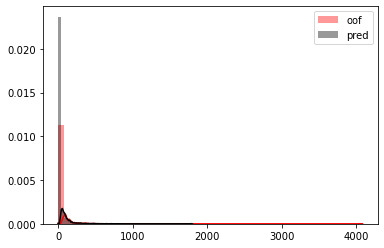

In [48]:
from make_fig import make_dist_oof_pred
make_dist_oof_pred(oof_df=oof_df,sub_df=sub_df,OUTPUT_DIR=OUTPUT_DIR)